# Galaxy-Quasar Classification

Author: Muhammad Fauzan Ishlah

#### Library and Data preparation

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from astropy.table import Table
import astropy.io.fits as fits
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_decision_regions

In [2]:
# data_url = 'https://anirut.space/data/sdss_galaxy_qso.fits' 

file = 'sdss_galaxy_qso.fits'
hdul = fits.open(file) 
data = hdul[1].data

##### Data Exploration

In [3]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  120 / width of table in bytes                        
NAXIS2  =                61843 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   18 / number of columns                              
EXTNAME = 'C:\Users\t_ton\Desktop\school\Skyserver_SQL8_2_2021 12_32_19 PM.f...'
TTYPE1  = 'objid   '           / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'ra      '           / label for column 2                             
TFORM2  = 'D       '        

##### Parameter that we will use

In [4]:
ra = data["ra"]
dec = data["dec"]
u = data['u']
g = data['g']
r = data['r']
i = data['i']
z = data['z']
obj_class = data["class"]
n = len(u)
print('Data size: {}'.format(n))

Data size: 61843


##### Assign class object for classification, where Galaxy = 0 and Quasar = 1

In [5]:
object_class = np.empty(n)
for j in range(0, n):
    if obj_class[j] == "GALAXY":
        object_class[j] = 0.0
    elif obj_class[j] == "QSO":
        object_class[j] = 1.0
    else:
        print(j)

Total QSO and Galaxy

Total QSO: 10603
Total GALAXY: 51240


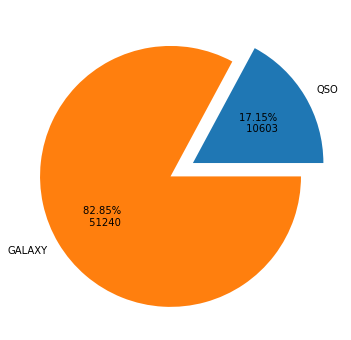

In [6]:
total_qso = (object_class == 1.0).sum()
total_glx = (object_class == 0.0).sum()
total_class = [total_qso, total_glx]
print('Total QSO: {}'.format(total_qso))
print('Total GALAXY: {}'.format(total_glx))
label_class = ['QSO', 'GALAXY']

def make_pct(values):
    def my_pct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n {v:d}'.format(p=pct,v=val)
    return my_pct

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(total_class, labels=label_class, explode= (0.1, 0.1), autopct=make_pct(total_class))
plt.show()

Position of each data in sky coordinate (RA vs DEC)

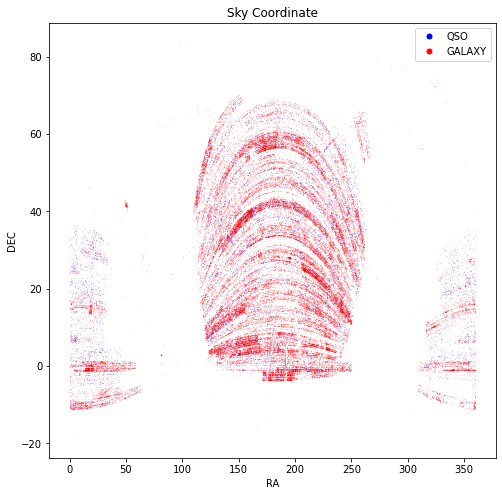

In [7]:
slct_qso = (object_class == 1.0)
slct_glx = (object_class == 0.0)
fig = plt.figure(figsize=(8,8))
plt.plot(ra[slct_qso], dec[slct_qso], 'b.', markersize=0.1, label='QSO')
plt.plot(ra[slct_glx], dec[slct_glx], 'r.', markersize=0.1, label='GALAXY')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(markerscale = 100)
plt.title('Sky Coordinate')
plt.show()

#### Color band relation
- ($u – g$) vs ($g – r$) 
- ($r – i$) vs ($i – z$)

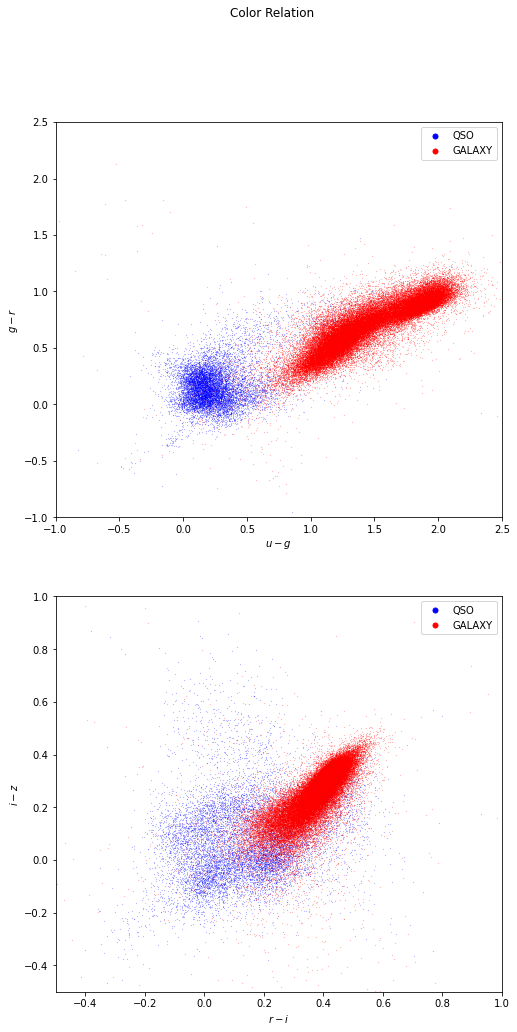

In [9]:
ug = u - g
gr = g - r
ri = r-i
iz = i-z

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,16))
ax1.plot(ug[slct_qso], gr[slct_qso], 'b.', markersize = 0.2, label = 'QSO')
ax1.plot(ug[slct_glx], gr[slct_glx], 'r.', markersize = 0.2, label = 'GALAXY')


ax2.plot(ri[slct_qso], iz[slct_qso], 'b.', markersize = 0.2, label = 'QSO')
ax2.plot(ri[slct_glx], iz[slct_glx], 'r.', markersize = 0.2, label = 'GALAXY')

ax1.set_xlim(-1, 2.5)
ax1.set_ylim(-1, 2.5)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

ax2.set_xlim(-0.5, 1)
ax2.set_ylim(-0.5, 1)
ax2.set_xlabel('$r - i$')
ax2.set_ylabel('$i - z$')

ax1.legend(markerscale = 50)
ax2.legend(markerscale = 50)

plt.suptitle('Color Relation')
plt.show()

#### Feature Selection
In this project, I use color band and color band relation as the features

In [10]:
features = np.stack((u, g, r, i, z, ug, gr, ri, iz), axis=-1)
print(features)

[[19.422102   18.037611   17.302042   ...  0.735569    0.37958717
   0.24535179]
 [18.116714   16.29402    15.389746   ...  0.904274    0.45203686
   0.39571285]
 [19.146093   18.174807   17.540287   ...  0.6345196   0.40590286
   0.19835472]
 ...
 [17.52649    16.152746   15.503484   ...  0.6492624   0.3587265
   0.2572117 ]
 [19.238003   17.693829   17.008457   ...  0.6853714   0.38658524
   0.24539185]
 [19.42646    17.48928    16.554274   ...  0.9350071   0.41840744
   0.31651878]]


#### Model Selection
For model selection, I test it for KNN Classifier

In [11]:
def model_knn(x_train, y_train, x_test, y_test, n, weight='uniform', algorithm='auto'):
    knn = KNeighborsClassifier(n_neighbors=n, weights=weight, algorithm=algorithm)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    knn_score = accuracy_score(y_test, y_pred)
    return [[n, weight, algorithm], knn_score]

##### Data split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(features, object_class, test_size=0.2, random_state=77)

##### Selecting model

In [13]:
def data_model(X, y, test_size, n):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    knn_weight = ['uniform', 'distance']
    knn_algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    knn_n_neighbors = np.arange(1, n+1)
    
    weight_test = []
    algorithm_test = []
    n_test = []
    score = []
    j=1
    for i in knn_n_neighbors:
        for w in knn_weight:
            for a in knn_algorithm:
                test = model_knn(x_train, y_train, x_test, y_test, i, weight=w, algorithm=a)
                n_test.append(test[0][0])
                weight_test.append(test[0][1])
                algorithm_test.append(test[0][2])
                score.append(test[1])
                print('Progress: {}/{}'.format(j, (2*4*n)), end='\r')
                if j == (2*4*n):
                    print('Complete')
                j+=1
    model = {
        'n_test': n_test,
        'weight': weight_test,
        'algorithm': algorithm_test,
        'score': score
    }
    return pd.DataFrame(data=model)

In [15]:
dataModel = data_model(features, object_class, 0.2, 10)

Complete: 80/80


In [16]:
dataModel.head()

,n_test,weight,algorithm,score
0,1,uniform,auto,0.978171
1,1,uniform,ball_tree,0.978171
2,1,uniform,kd_tree,0.978171
3,1,uniform,brute,0.978171
4,1,distance,auto,0.978171


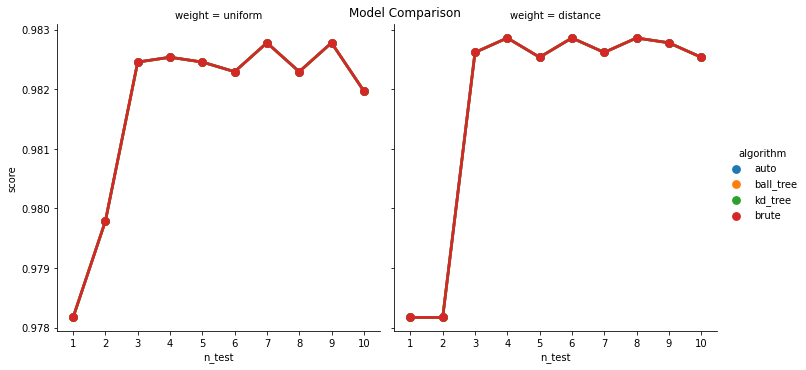

In [52]:
# fig, ax = plt.subplot()
ax = sns.catplot(data=dataModel,
               x='n_test',
                y='score',
                hue='algorithm',
                col='weight',
                kind='point'
               )
ax.fig.suptitle('Model Comparison')
plt.show()

In [18]:
scoreMaxCond = (dataModel['score'] == dataModel['score'].max())
dataModel.loc[scoreMaxCond, :]

,n_test,weight,algorithm,score
28,4,distance,auto,0.98286
29,4,distance,ball_tree,0.98286
30,4,distance,kd_tree,0.98286
31,4,distance,brute,0.98286
44,6,distance,auto,0.98286
45,6,distance,ball_tree,0.98286
46,6,distance,kd_tree,0.98286
47,6,distance,brute,0.98286
60,8,distance,auto,0.98286
61,8,distance,ball_tree,0.98286


The best model
- n_neigbors = 7
- weight = distance

#### Testing the model

In [19]:
x_train, x_test, y_train, y_test = train_test_split(features, object_class, test_size=0.2, random_state=77)

In [23]:
clf = KNeighborsClassifier(n_neighbors=7, weights='distance')
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()

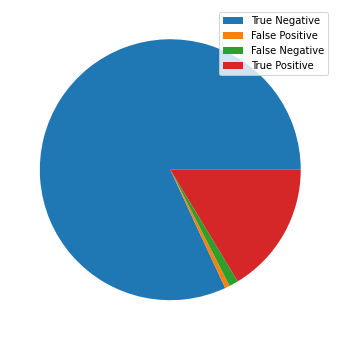

In [35]:
confusionMatrix = [tn, fp, fn, tp]
confusion_label = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(confusionMatrix, labeldistance = 1.2)
plt.legend(confusion_label)
plt.show()